In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Load Dataset
df = pd.read_csv("insurance.csv")

In [3]:
# Handle Missing Data
print(df.isnull().values.any())

False


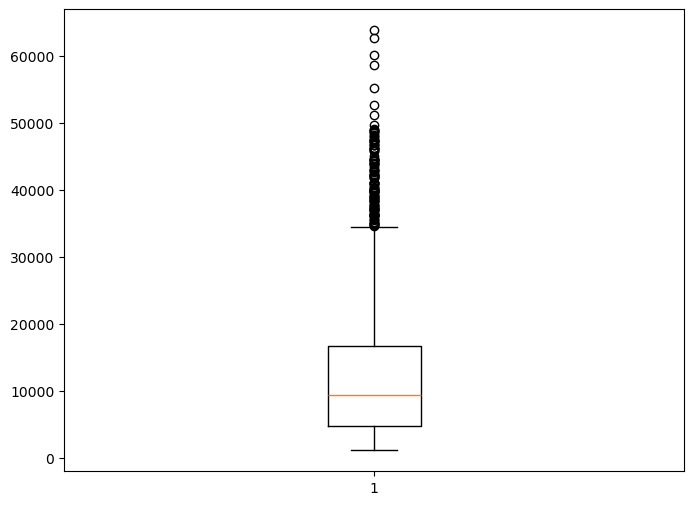

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
# Handle Outlier
plt.figure(figsize=(8, 6))
plt.boxplot(df['charges'])
plt.show()
Q1 = df['charges'].quantile(0.25)
Q3 = df['charges'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_cleaned = df[(df['charges'] < lower_bound) | (df['charges'] > upper_bound)]
df[(df['charges']>= lower_bound) & (df['charges']<= upper_bound)]

In [9]:
# Convert categorical features
df_cleaned = df.copy()

encoder_sex = OrdinalEncoder(categories = [['male', 'female']])
df['sex_encoded'] = encoder_sex.fit_transform(df[['sex']]).astype(int)

encoder_smoker = OrdinalEncoder(categories = [['no', 'yes']])
df['smoker_encoded'] = encoder_smoker.fit_transform(df[['smoker']]).astype(int)

encoder_region = OrdinalEncoder(categories = [['northeast', 'northwest', 'southeast', 'southwest']])
df['region_encoded'] = encoder_region.fit_transform(df[['region']]).astype(int)

df_cleaned.drop(['sex', 'smoker', 'region'], axis = 1, inplace = True)

print(df_cleaned.head())

   age     bmi  children      charges
0   19  27.900         0  16884.92400
1   18  33.770         1   1725.55230
2   28  33.000         3   4449.46200
3   33  22.705         0  21984.47061
4   32  28.880         0   3866.85520


In [11]:
# Scale data
scaler = MinMaxScaler()
features = df_cleaned.drop('charges', axis = 1)
scaled_features = scaler.fit_transform(features)
df_scaled = pd.DataFrame(scaled_features, columns = features.columns)
df_scaled['charges'] = df_cleaned['charges']

R-squared:  0.16301209866339939


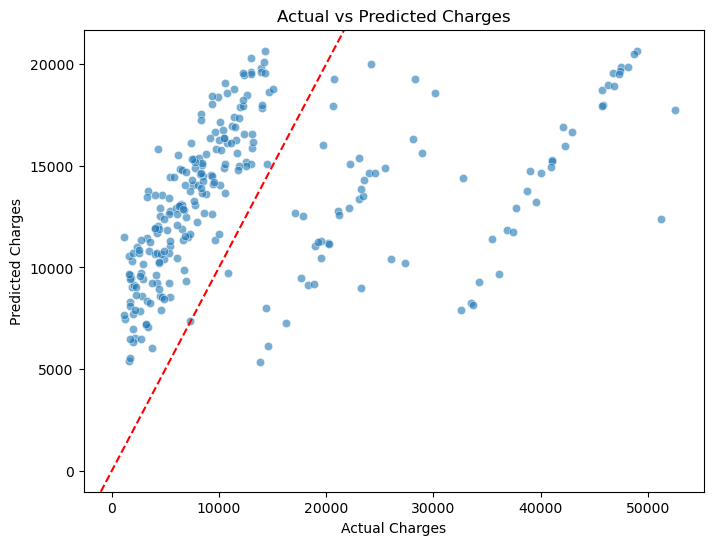

In [13]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import joblib

X = df_cleaned.drop(columns = ['charges'])
y = df_cleaned['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
score = r2_score(y_test, y_pred)
print('R-squared: ', score)

# Plot results
plt.figure(figsize = (8, 6))
sns.scatterplot(x = y_test, y = y_pred, alpha = 0.6)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
plt.axline([0, 0], [1, 1], color = 'red', linestyle = 'dashed')
plt.show()

joblib.dump(lr, 'insurance_charge_model.pkl')
loaded_model = joblib.load('insurance_charge_model.pkl')
Y_hat = loaded_model.predict(X)


0.1556631997784631 134359283.20643726


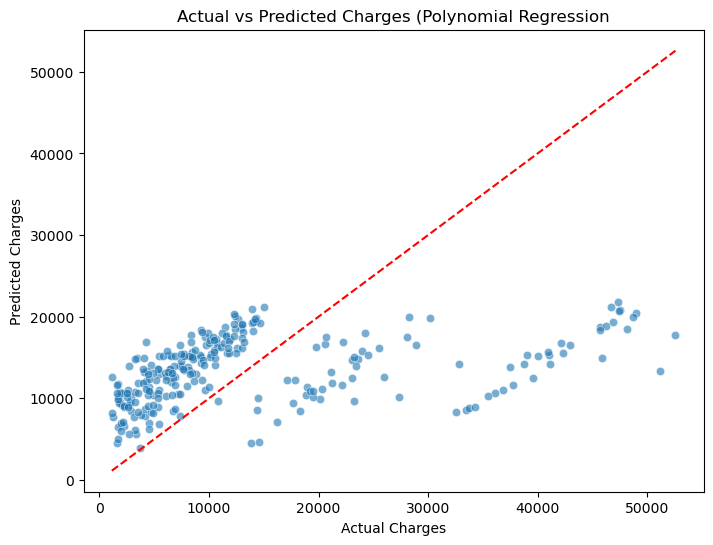

In [15]:
# Polynomial Regression
X = df_scaled.drop(columns=['charges']).to_numpy()
y = df_scaled['charges'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

poly = PolynomialFeatures(degree = 2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lin = LinearRegression()
lin.fit(X_train_poly, y_train)

y_pred_poly = lin.predict(X_test_poly)

r2 = r2_score(y_test, y_pred_poly)
mse = mean_squared_error(y_test, y_pred_poly)
print (r2, mse)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_poly, alpha=0.6)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges (Polynomial Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='dashed')  # Fixed diagonal line
plt.show()

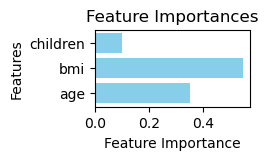

In [26]:
importances = rf.feature_importances_
feature_names = df_cleaned.drop(columns=['charges']).columns

plt.figure(figsize=(2, 1))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

MSE Train:  84714906.52777416
MSE Test:  215997062.44191745
R2 Train:  0.40910105849176037
R2 Test:  -0.3573626191444461


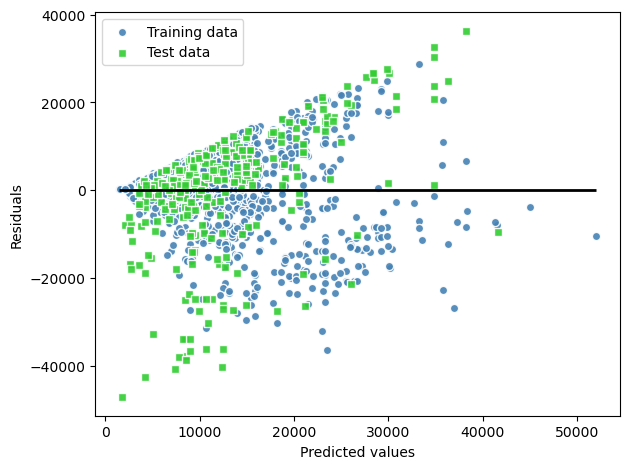

In [30]:
from sklearn.ensemble import RandomForestRegressor

X = df_cleaned['bmi'].values.reshape(-1,1)
y = df_cleaned['charges'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

rf = RandomForestRegressor(n_estimators=10, bootstrap=True, random_state = 0)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

mseTrain = mean_squared_error(y_train, y_train_pred)
mseTest = mean_squared_error(y_test, y_test_pred)
print ("MSE Train: ", mseTrain)
print ("MSE Test: ", mseTest)

r2Train = r2_score(y_train, y_train_pred)
r2Test = r2_score(y_test, y_test_pred)
print ("R2 Train: ", r2Train)
print ("R2 Test: ", r2Test)

plt.scatter(y_train_pred,
            y_train_pred - y_train,
            c='steelblue',
            edgecolor='white',
            marker='o',
            s=35,
            alpha=0.9,
            label='Training data')
plt.scatter(y_test_pred,
            y_test_pred - y_test,
            c='limegreen',
            edgecolor='white',
            marker='s',
            s=35,
            alpha=0.9,
            label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=min(y_train_pred), xmax=max(y_train_pred), lw=2, color='black')
plt.tight_layout()
plt.show()